# New Model Training XGBoost

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .otherwise(-1))  

feature_columns = [
    # Field Position and Game Context
    'yardline_100', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'score_differential_post', 'posteam_score_post',
    'quarter_seconds_remaining', 'half_seconds_remaining', 'drive', 'score_differential',
    'game_seconds_remaining',

    # Play History
    'play_success', 'cumulative_rush_attempts', 'cumulative_pass_attempts', 
    'cumulative_rush_successes', 'cumulative_pass_successes', 'rush_success_rate', 
    'pass_success_rate', 'posteam_leading', 'posteam_trailing',

    # Down, Defense, and Special Teams Context
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed',
    'sack', 'touchback', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 'punt_out_of_bounds'
]


assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

games = df_vector.select("game_id").distinct().collect()  
train_games = games[:int(0.8 * len(games))] 
test_games = games[int(0.8 * len(games)):]

train_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in train_games]))
test_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in test_games]))

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score,  accuracy_score, precision_score, recall_score

# === 1. CONVERT DATA TO PANDAS === #
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Convert feature vectors back to NumPy arrays
X_train = np.array(train_pandas["features"].tolist())
y_train = np.array(train_pandas["play_type_index"].tolist())

X_test = np.array(test_pandas["features"].tolist())
y_test = np.array(test_pandas["play_type_index"].tolist())

# === 2. TRAIN XGBOOST MODEL === #
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=4,  # 4 play types: Run, Pass, Punt, FG
    max_depth=6,  # Standard tree depth
    learning_rate=0.1,  # Default learning rate
    n_estimators=100,  # Number of boosting rounds
    scale_pos_weight=5,  # Helps with class imbalance
    random_state=42
)

xgb.fit(X_train, y_train)

# === 3. MAKE PREDICTIONS === #
y_pred = xgb.predict(X_test)

# === 4. EVALUATE MODEL === #
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

# Print overall classification metrics
print("\n✅ Overall Model Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     41452
           1       0.79      0.82      0.80     29021
           2       1.00      1.00      1.00      5139
           3       0.99      0.99      0.99      2175

    accuracy                           0.85     77787
   macro avg       0.91      0.91      0.91     77787
weighted avg       0.85      0.85      0.85     77787


✅ Overall Model Performance:
  Accuracy:  0.8495
  Precision: 0.8507
  Recall:    0.8495
  F1 Score:  0.8499


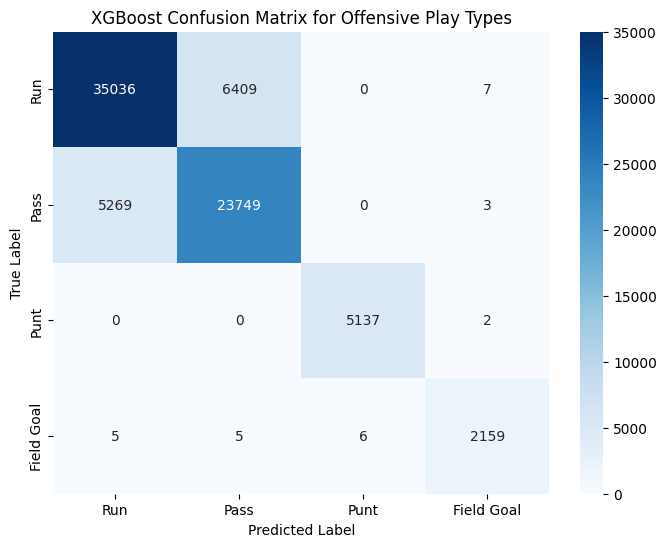

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["Run", "Pass", "Punt", "Field Goal"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix for Offensive Play Types")
plt.show()

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score,  accuracy_score, precision_score, recall_score
from pyspark.sql.functions import col

# === 1. CONVERT DATA TO PANDAS === #
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Convert feature vectors back to NumPy arrays
X_train = np.array(train_pandas["features"].tolist())
y_train = np.array(train_pandas["play_type_index"].tolist())

X_test = np.array(test_pandas["features"].tolist())
y_test = np.array(test_pandas["play_type_index"].tolist())

# === 2. TRAIN XGBOOST MODEL === #
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=4,  # 4 play types: Run, Pass, Punt, FG
    max_depth=9,  # Standard tree depth
    learning_rate=0.05,  # Default learning rate
    n_estimators=100,  # Number of boosting rounds
    scale_pos_weight=2,  # Helps with class imbalance
    random_state=42
)

xgb.fit(X_train, y_train)

# === 3. MAKE PREDICTIONS === #
y_pred = xgb.predict(X_test)

# === 4. EVALUATE MODEL === #
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

# Print overall classification metrics
print("\n✅ Overall Model Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     41452
           1       0.79      0.81      0.80     29021
           2       1.00      1.00      1.00      5139
           3       1.00      0.99      0.99      2175

    accuracy                           0.85     77787
   macro avg       0.91      0.91      0.91     77787
weighted avg       0.85      0.85      0.85     77787


✅ Overall Model Performance:
  Accuracy:  0.8487
  Precision: 0.8497
  Recall:    0.8487
  F1 Score:  0.8491


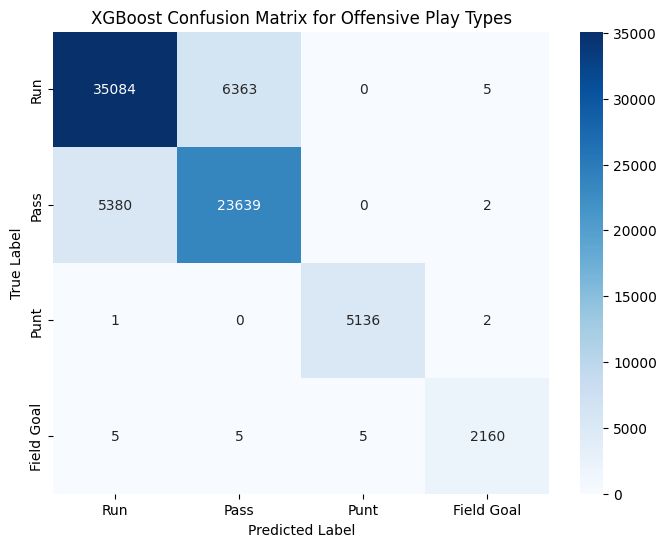

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["Run", "Pass", "Punt", "Field Goal"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix for Offensive Play Types")
plt.show()

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score,  accuracy_score, precision_score, recall_score

# === 1. CONVERT DATA TO PANDAS === #
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Convert feature vectors back to NumPy arrays
X_train = np.array(train_pandas["features"].tolist())
y_train = np.array(train_pandas["play_type_index"].tolist())

X_test = np.array(test_pandas["features"].tolist())
y_test = np.array(test_pandas["play_type_index"].tolist())

# === 2. TRAIN XGBOOST MODEL === #
xgb = XGBClassifier(
    max_depth=9,  
    learning_rate=0.05,  
    n_estimators=200,  
    scale_pos_weight=1,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42
)

xgb.fit(X_train, y_train)

# === 3. MAKE PREDICTIONS === #
y_pred = xgb.predict(X_test)

# === 4. EVALUATE MODEL === #
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

# Print overall classification metrics
print("\n✅ Overall Model Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     41452
           1       0.79      0.82      0.81     29021
           2       1.00      1.00      1.00      5139
           3       1.00      0.99      1.00      2175

    accuracy                           0.85     77787
   macro avg       0.92      0.92      0.92     77787
weighted avg       0.85      0.85      0.85     77787


✅ Overall Model Performance:
  Accuracy:  0.8535
  Precision: 0.8544
  Recall:    0.8535
  F1 Score:  0.8539


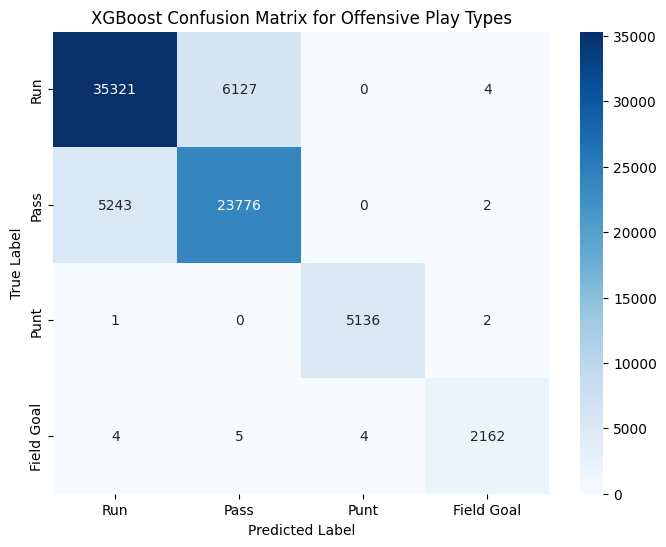

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["Run", "Pass", "Punt", "Field Goal"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix for Offensive Play Types")
plt.show()